### Seminar 9: exploration vs exploitation

In this seminar, we'll employ bayesian neural networks to facilitate exploration in contextual bandits.

__About bayesian neural networks:__
  * A post on the matter - [url](http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/)
  * Theano+PyMC3 for more serious stuff - [url](http://pymc-devs.github.io/pymc3/notebooks/bayesian_neural_network_advi.html)
  * Same stuff in tensorflow - [url](http://edwardlib.org/tutorials/bayesian-neural-network)


In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In this seminar, we're going to solve a toy contextual bandit problem
* 60-dimensional states
* 10 actions
* rewards between 0 and 1

Instead of actually running on a stream of data, we're gonna emulate it with samples from dataset.

In [49]:
all_states = np.load("all_states.npy")
action_rewards = np.load("action_rewards.npy")

state_size = all_states.shape[1]
n_actions = action_rewards.shape[1]
print ("%id states, %i actions"%(state_size,n_actions))

60d states, 10 actions


In [50]:
import theano, theano.tensor as T
import lasagne
from lasagne import init
from lasagne.layers import *
import bayes
as_bayesian = bayes.bbpwrap(bayes.NormalApproximation(std=0.1))
BayesDenseLayer = as_bayesian(DenseLayer)
#similar: BayesConv2DLayer = as_bayesian(Conv2DLayer)

In [51]:
class Bandit:
    """a bandit with bayesian neural net"""
    def __init__(self,state_size=state_size,n_actions=n_actions):
        
        #input variables
        input_states = T.matrix("states")
        target_actions = T.ivector("actions taken")
        target_rewards = T.vector("rewards")
        
        self.total_samples_seen = theano.shared(np.int32(0),"number of training samples seen so far")
        
        batch_size = target_actions.shape[0]

        
        ###
        #network body
        inp = InputLayer((None,state_size),name='input')

        hid = BayesDenseLayer(inp,50,nonlinearity=lasagne.nonlinearities.rectify) #<create bayesian dense layer for hidden states>
        
        out = BayesDenseLayer(hid, n_actions, nonlinearity=None)#<create bayesian dense layer that predicts Q's aka actions>

        ###
        #prediction
        
        prediction_all_actions = get_output(out,inputs=input_states)
        
        self.predict_sample_rewards = theano.function([input_states],prediction_all_actions)

        ###
        #Training

        #select prediction for target action
        prediction_target_actions = prediction_all_actions[T.arange(batch_size),target_actions]

        #loss = negative log-likelihood (mse) + KL
        negative_llh = T.sum((prediction_target_actions - target_rewards)**2) 
        
        kl = bayes.get_var_cost(out) / (self.total_samples_seen+batch_size)
        
        loss = (negative_llh + kl)/batch_size

        self.weights = get_all_params(out,trainable=True)
        self.out=out

        #gradient descent
        updates = lasagne.updates.adam(loss,self.weights)
        #update counts
        updates[self.total_samples_seen]=self.total_samples_seen+batch_size.astype('int32')
        
        self.train_step = theano.function([input_states,target_actions,target_rewards],
                                          [negative_llh,kl],updates = updates,
                                          allow_input_downcast=True)
    
    
    def sample_prediction(self,states,n_samples=1):
        """Samples n_samples predictions for rewards,
        
        :returns: tensor [n_samples,state_i,action_i]
        """
        assert states.ndim==2,"states must be 2-dimensional"
        
        return np.stack([self.predict_sample_rewards(states) for _ in range(n_samples)])
    
    
    epsilon=0.25
    def get_action(self,states):
        """
        Picks action by 
        - with p=1-epsilon, taking argmax of average rewards
        - with p=epsilon, taking random action
        This is exactly e-greedy policy.
        """
        
        reward_samples = self.sample_prediction(states,n_samples=100)
        #^-- samples for rewards, shape = [n_samples,n_states,n_actions]
        
        best_actions = reward_samples.mean(axis=0).argmax(axis=-1)
        #^-- we take mean over samples to compute expectation, then pick best action with argmax 
        epsilon = self.epsilon
        
        mask_exploration = np.random.binomial(1, epsilon,size = len(states))
        
        random_actions = np.random.randint(0, n_actions,size = len(states))#<generate random actions>
        
        chosen_actions = np.where(mask_exploration==1, random_actions, best_actions)
        #[random_actions[i] if mask_exploration[i] == 1 else best_actions[i] for i in range(100)]
        #<<pick actions with e-greedy policy>
        
        return chosen_actions
    
    def train(self,states,actions,rewards,n_iters=10):
        """
        trains to predict rewards for chosen actions in given states
        """
        
        loss_sum = kl_sum = 0
        for _ in range(n_iters):
            loss,kl = self.train_step(states,actions,rewards)
            loss_sum += loss
            kl_sum += kl

            
        return loss_sum/n_iters,kl_sum/n_iters

### Train the bandit

We emulate infinite stream of data and pick actions using agent's get_action function.

In [52]:
bandit = Bandit() #create your bandit

rewards_history = []

In [53]:
def get_new_samples(states,action_rewards,batch_size=10):
    """samples random minibatch, emulating new users"""
    batch_ix = np.random.randint(0,len(states),batch_size)
    return states[batch_ix],action_rewards[batch_ix]

iteration #990	mean reward=0.760	mse=0.125	kl=0.006


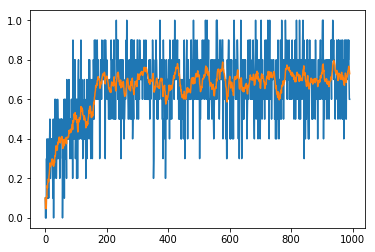

Q(s,a) std: 0.016;0.012;0.013;0.013;0.011;0.011;0.011;0.009;0.016;0.012
correct 1


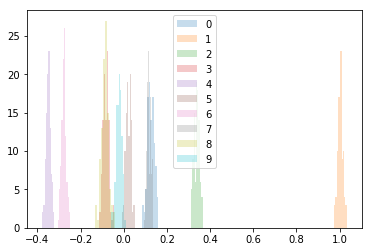

In [54]:
from IPython.display import clear_output
from pandas import ewma

batch_size=10 #10 new users

for i in range(1000):
    ###
    #new data
    b_states,b_action_rewards = get_new_samples(all_states,action_rewards,batch_size)
    
    ###
    #pick actions
    b_actions = bandit.get_action(b_states)
    
    ###
    #rewards for actions agent just took
    b_rewards = b_action_rewards[np.arange(batch_size),b_actions]
    
    ###
    #train bandit
    mse,kl = bandit.train(b_states,b_actions,b_rewards,n_iters=100)
    
    rewards_history.append(b_rewards.mean())
    
    if i%10 ==0:
        clear_output(True)
        print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f"%(i,np.mean(rewards_history[-10:]),mse,kl))
        plt.plot(rewards_history)
        plt.plot(ewma(np.array(rewards_history),alpha=0.1))
        plt.show()
        samples = bandit.sample_prediction(b_states[:1],n_samples=100).T[:,0,:]
        for i in range(len(samples)):
            plt.hist(samples[i],alpha=0.25,label=str(i))
            plt.legend(loc='best')
        print('Q(s,a) std:', ';'.join(list(map('{:.3f}'.format,np.std(samples,axis=1)))))
        print('correct',b_action_rewards[0].argmax())
        plt.show()

## Better exploration

You will now implement the two exploration strategies from the lecture.

In [55]:
#then implement it and replace bandit = Bandit() above with ThompsonBandit()
class ThompsonBandit(Bandit):
    def get_action(self,states):
        """
        picks action based by taking _one_ sample from BNN and taking action with highest sampled reward 
        (yes, that simple)
        This is exactly thompson sampling.
        """
        reward_samples = self.sample_prediction(states,n_samples=1)
        #^-- samples for rewards, shape = [n_samples,n_states,n_actions]
        print(reward_samples.shape)
        best_actions = reward_samples.argmax(axis=-1)
     
        return best_actions[0]
        


In [56]:
thom = ThompsonBandit()

In [57]:
b_states,b_action_rewards = get_new_samples(all_states,action_rewards,batch_size)
thom.get_action(b_states), b_states.shape

(1, 10, 10)


(array([1, 5, 8, 5, 1, 5, 5, 5, 8, 5]), (10, 60))

In [58]:
#then implement it and replace bandit = Bandit() above with UCBBandit()

class UCBBandit(Bandit):
    q = 90
    def get_action(self,states):
        """
        Compute q-th percentile of rewards P(r|s,a) for all actions
        Take actions that have highest percentiles.
        
        This implements bayesian UCB strategy
        """
        
        #<Your code here>
        
        rewards_samples = self.sample_prediction(states,n_samples = 1000)
        
        percetile = np.percentile(rewards_samples, self.q, axis =0)
        

        return percetile.argmax(-1)#<actions with bayesian ucb>


In [59]:
bandit = UCBBandit(state_size, n_actions)

In [60]:
#bandit = UCBBandit(state_size, n_actions)#<UCBBandit or ThompsonBandit>
#<maybe change parameters>

rewards_history = []

iteration #990	mean reward=0.870	mse=0.174	kl=0.007


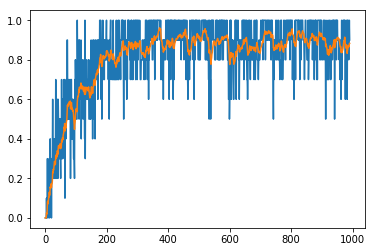

Q(s,a) std: 0.052;0.017;0.014;0.024;0.173;0.015;0.115;0.034;0.033;0.012
correct 1


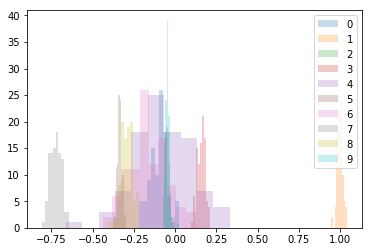

In [47]:
from IPython.display import clear_output
from pandas import ewma

batch_size=10 #10 new users

for i in range(1000):
    ###
    #new data
    b_states,b_action_rewards = get_new_samples(all_states,action_rewards,batch_size)
    
    ###
    #pick actions
    b_actions = bandit.get_action(b_states)
    
    ###
    #rewards for actions agent just took
    b_rewards = b_action_rewards[np.arange(batch_size),b_actions]
    
    ###
    #train bandit
    mse,kl = bandit.train(b_states,b_actions,b_rewards,n_iters=100)
    
    rewards_history.append(b_rewards.mean())
    
    if i%10 ==0:
        clear_output(True)
        print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f"%(i,np.mean(rewards_history[-10:]),mse,kl))
        plt.plot(rewards_history)
        plt.plot(ewma(np.array(rewards_history),alpha=0.1))
        plt.show()
        samples = bandit.sample_prediction(b_states[:1],n_samples=100).T[:,0,:]
        for i in range(len(samples)):
            plt.hist(samples[i],alpha=0.25,label=str(i))
            plt.legend(loc='best')
        print('Q(s,a) std:', ';'.join(list(map('{:.3f}'.format,np.std(samples,axis=1)))))
        print('correct',b_action_rewards[0].argmax())
        plt.show()

### Experience replay

Our value-based bandit algorithm is off-policy, so we can train it on actions from a different policy.

For example, the bandit will need much less interactions to converge if you train it on past experiences. You can also pre-train it on any data you already have.

In [62]:
import random

In [119]:
class ReplayBandit(Bandit): #or your preferred exploration type
    """A bandit that trains not on last user interactions but on random samples from everything it saw"""
    experience_buffer = []
    
    def __init__(self,state_size=state_size,n_actions=n_actions):
        
        #input variables
        input_states = T.matrix("states")
        target_actions = T.ivector("actions taken")
        target_rewards = T.vector("rewards")
        
        self.total_samples_seen = theano.shared(np.int32(0),"number of training samples seen so far")
        
        batch_size = target_actions.shape[0]

        
        ###
        #network body
        inp = InputLayer((None,state_size),name='input')

        hid = BayesDenseLayer(inp,50,nonlinearity=lasagne.nonlinearities.rectify) #<create bayesian dense layer for hidden states>
        
        out = BayesDenseLayer(hid, n_actions, nonlinearity=None)#<create bayesian dense layer that predicts Q's aka actions>

        ###
        #prediction
        
        prediction_all_actions = get_output(out,inputs=input_states)
        
        self.predict_sample_rewards = theano.function([input_states],prediction_all_actions)

        ###
        #Training

        #select prediction for target action
        prediction_target_actions = prediction_all_actions[T.arange(batch_size),target_actions]

        #loss = negative log-likelihood (mse) + KL
        negative_llh = T.sum((prediction_target_actions - target_rewards)**2) 
        
        kl = bayes.get_var_cost(out) / (self.total_samples_seen+batch_size)
        
        loss = (negative_llh + kl)/batch_size

        self.weights = get_all_params(out,trainable=True)
        self.out=out

        #gradient descent
        updates = lasagne.updates.adam(loss,self.weights)
        #update counts
        updates[self.total_samples_seen]=self.total_samples_seen+batch_size.astype('int32')
        
        self.train_step = theano.function([input_states,target_actions,target_rewards],
                                          [negative_llh,kl],updates = updates,
                                          allow_input_downcast=True)
    
    
    def sample_prediction(self,states,n_samples=1):
        """Samples n_samples predictions for rewards,
        
        :returns: tensor [n_samples,state_i,action_i]
        """
        assert states.ndim==2,"states must be 2-dimensional"
        
        return np.stack([self.predict_sample_rewards(states) for _ in range(n_samples)])
    
    
    epsilon=0.25
    def get_action(self,states):
        """
        Picks action by 
        - with p=1-epsilon, taking argmax of average rewards
        - with p=epsilon, taking random action
        This is exactly e-greedy policy.
        """
        
        reward_samples = self.sample_prediction(states,n_samples=100)
        #^-- samples for rewards, shape = [n_samples,n_states,n_actions]
        
        best_actions = reward_samples.mean(axis=0).argmax(axis=-1)
        #^-- we take mean over samples to compute expectation, then pick best action with argmax 
        epsilon = self.epsilon
        
        mask_exploration = np.random.binomial(1, epsilon,size = len(states))
        
        random_actions = np.random.randint(0, n_actions,size = len(states))#<generate random actions>
        
        chosen_actions = np.where(mask_exploration==1, random_actions, best_actions)
        #[random_actions[i] if mask_exploration[i] == 1 else best_actions[i] for i in range(100)]
        #<<pick actions with e-greedy policy>
        
        return chosen_actions
    def sample(self, batch_size):
        
        idxes = np.random.randint(0, len(self.experience_buffer), size = batch_size)#<randomly generate indexes of samples>
        
        states, actions, rewards = [], [], [] 
        
        ###Your code: collect <s,a,r,s',done> for each index
        for i in idxes:
            s, a, r = self.experience_buffer[i]
            states += [s] 
            actions += [a] 
          
            rewards += [r] 
           
        #print(np.array(s).shape, np.array(states).shape, 'in sample')
        return states, actions, rewards

    def train(self,states,actions,rewards,n_iters=10):
        """
        trains to predict rewards for chosen actions in given states
        """
        #print('old', states)
        for i in range(len(states)):
            self.experience_buffer += [(states[i], actions[i], rewards[i])]
        new_states, new_actions, new_rewards = self.sample(batch_size)
        #print('before train', np.array(states).shape, np.array(new_states).shape)
        new_states = np.concatenate([states, new_states])
        new_actions = np.concatenate([actions, new_actions])
        new_rewards = np.concatenate([rewards, new_rewards])
        
        #print('after', np.array(states).shape, np.array(new_states).shape)
        #print('new', new_states)
        loss_sum = kl_sum = 0
        for _ in range(n_iters):
            
            loss,kl = self.train_step(new_states, new_actions, new_rewards)
            loss_sum += loss
            kl_sum += kl

            
        return loss_sum/n_iters,kl_sum/n_iters
    
    

In [120]:
new_bandit = ReplayBandit()

iteration #990	mean reward=0.780	mse=0.119	kl=0.005


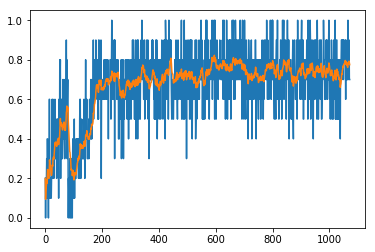

Q(s,a) std: 0.505;0.470;0.446;0.469;0.383;0.491;0.420;0.489;0.425;0.437
correct 5


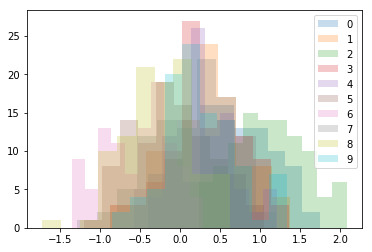

In [121]:
from IPython.display import clear_output
from pandas import ewma

batch_size=10 #10 new users

for i in range(1000):
    ###
    #new data
    b_states,b_action_rewards = get_new_samples(all_states,action_rewards,batch_size)
    
    ###
    #pick actions
    b_actions = new_bandit.get_action(b_states)
    
    ###
    #rewards for actions agent just took
    b_rewards = b_action_rewards[np.arange(batch_size),b_actions]
    
    ###
    #train bandit
    mse,kl = new_bandit.train(b_states,b_actions,b_rewards,n_iters=100)
    
    rewards_history.append(b_rewards.mean())
    
    if i%10 ==0:
        clear_output(True)
        print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f"%(i,np.mean(rewards_history[-10:]),mse,kl))
        plt.plot(rewards_history)
        plt.plot(ewma(np.array(rewards_history),alpha=0.1))
        plt.show()
        samples = bandit.sample_prediction(b_states[:1],n_samples=100).T[:,0,:]
        for i in range(len(samples)):
            plt.hist(samples[i],alpha=0.25,label=str(i))
            plt.legend(loc='best')
        print('Q(s,a) std:', ';'.join(list(map('{:.3f}'.format,np.std(samples,axis=1)))))
        print('correct',b_action_rewards[0].argmax())
        plt.show()

In [122]:
#then implement it and replace bandit = Bandit() above with UCBBandit()

class UCBBanditER(Bandit):
    q = 90
    def get_action(self,states):
        """
        Compute q-th percentile of rewards P(r|s,a) for all actions
        Take actions that have highest percentiles.
        
        This implements bayesian UCB strategy
        """
        
        #<Your code here>
        
        rewards_samples = self.sample_prediction(states,n_samples = 1000)
        
        percetile = np.percentile(rewards_samples, self.q, axis =0)
        

        return percetile.argmax(-1)#<actions with bayesian ucb>


In [125]:
new_bandit = UCBBanditER()

iteration #990	mean reward=0.940	mse=0.074	kl=0.007


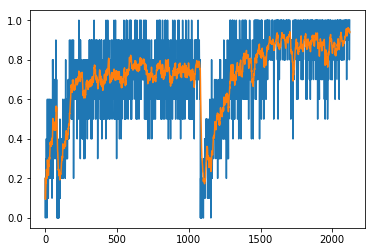

Q(s,a) std: 0.586;0.475;0.518;0.506;0.436;0.498;0.493;0.457;0.450;0.551
correct 2


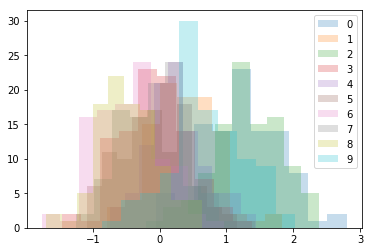

In [126]:
batch_size=10 #10 new users

for i in range(1000):
    ###
    #new data
    b_states,b_action_rewards = get_new_samples(all_states,action_rewards,batch_size)
    
    ###
    #pick actions
    b_actions = new_bandit.get_action(b_states)
    
    ###
    #rewards for actions agent just took
    b_rewards = b_action_rewards[np.arange(batch_size),b_actions]
    
    ###
    #train bandit
    mse,kl = new_bandit.train(b_states,b_actions,b_rewards,n_iters=100)
    
    rewards_history.append(b_rewards.mean())
    
    if i%10 ==0:
        clear_output(True)
        print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f"%(i,np.mean(rewards_history[-10:]),mse,kl))
        plt.plot(rewards_history)
        plt.plot(ewma(np.array(rewards_history),alpha=0.1))
        plt.show()
        samples = bandit.sample_prediction(b_states[:1],n_samples=100).T[:,0,:]
        for i in range(len(samples)):
            plt.hist(samples[i],alpha=0.25,label=str(i))
            plt.legend(loc='best')
        print('Q(s,a) std:', ';'.join(list(map('{:.3f}'.format,np.std(samples,axis=1)))))
        print('correct',b_action_rewards[0].argmax())
        plt.show()